<a href="https://colab.research.google.com/github/alexngocvu/Heart-Disease-and-Lifestyle/blob/main/Clustering_(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings #for clean outputs
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import chi2_contingency

In [ ]:
from google.colab import files #uploading file
uploaded = files.upload()

Saving heart_disease_yes.csv to heart_disease_yes.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# --- Configuration ---
# 🚨 IMPORTANT: Replace 'heart_disease_yes.csv' if your file has a different name/extension.
file_name = 'heart_disease_yes.csv'
# --- End Configuration ---

# 1. Load Data
try:
    df = pd.read_csv(file_name)
    print(f"✅ Successfully loaded file: {file_name}. Rows: {len(df)}")
except FileNotFoundError:
    print(f"❌ ERROR: File '{file_name}' not found. Check that the name is EXACTLY correct and the file is uploaded.")
    raise

# 2. Identify and Process Features
# A. Handle Missing Values: Drop rows with any missing data (simple approach)
df.dropna(inplace=True)

# B. Separate Numerical and Categorical Columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print(f"\nTotal Features: {len(df.columns)}")
print(f"Numerical features identified: {len(numerical_cols)}")
print(f"Categorical features identified: {len(categorical_cols)}")

# C. One-Hot Encode Categorical Variables
# This converts each category into a new binary (0 or 1) numerical feature.
df_processed = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# D. Final Feature Set
clustering_features = df_processed.columns.tolist()

# Remove the original numerical columns that were not transformed (already numeric)
# If your dataset included an ID column, you might want to remove it here as well.

# The final dataset X now includes all original numerical columns and all new one-hot encoded columns.
X = df_processed.select_dtypes(include=np.number).copy()
clustering_features = X.columns.tolist()
print(f"\nReady to cluster on {len(clustering_features)} features (Originals + One-Hot Encoded).")

# 3. Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data loaded, processed, and scaled successfully.")

✅ Successfully loaded file: heart_disease_yes.csv. Rows: 27373

Total Features: 18
Numerical features identified: 4
Categorical features identified: 14

Ready to cluster on 4 features (Originals + One-Hot Encoded).
Data loaded, processed, and scaled successfully.


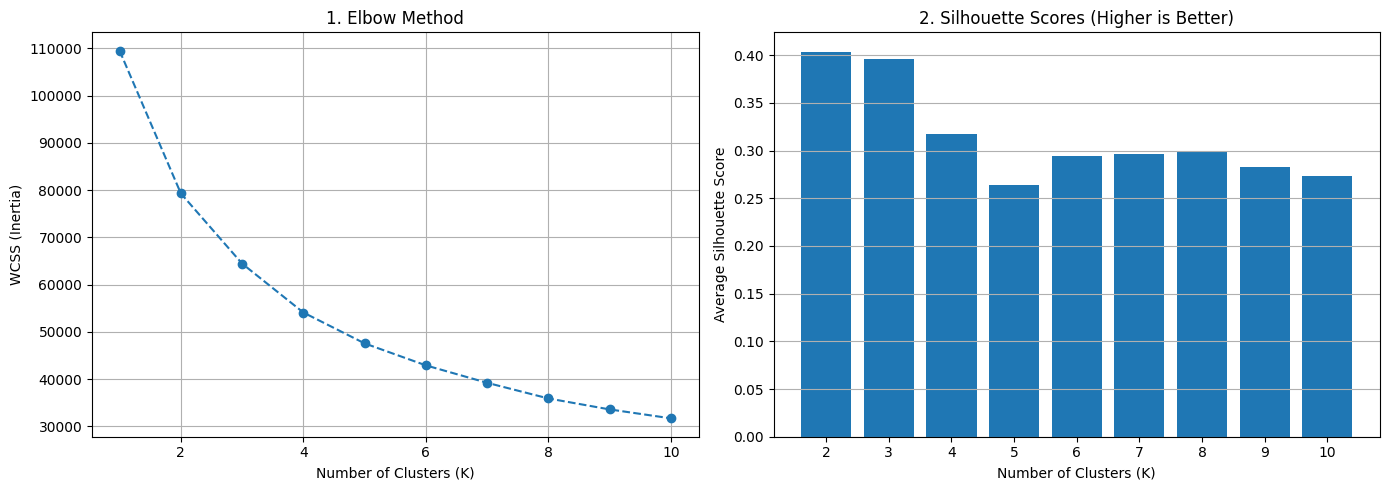


--- Analysis of Optimal K ---
1. **Elbow Method**: Look for the K where the WCSS curve starts to flatten.
2. **Silhouette Score**: Choose the K with the highest score.


In [ ]:
wcss = []
silhouette_scores = {}
max_k = 10  # Test up to 10 clusters
k_range = range(2, max_k + 1)

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

    if k in k_range:
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores[k] = score

# --- Plotting the Results ---
plt.figure(figsize=(14, 5))

# Elbow Method Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--')
plt.title('1. Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)


# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.bar(silhouette_scores.keys(), silhouette_scores.values())
plt.title('2. Silhouette Scores (Higher is Better)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Silhouette Score')
plt.xticks(list(k_range))
plt.grid(axis='y')


plt.tight_layout()
plt.show()

print("\n--- Analysis of Optimal K ---")
print("1. **Elbow Method**: Look for the K where the WCSS curve starts to flatten.")
print("2. **Silhouette Score**: Choose the K with the highest score.")

In [ ]:
# 🛑 ACTION REQUIRED: Based on the plots in Step 2, set your final K value here.
optimal_k = 4 # 👈 CHANGE THIS VALUE

print(f"--- Running Final K-Means with Optimal K = {4} ---")

# 4. Apply Final K-Means Model
kmeans_final = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster assignments to the processed DataFrame
X['Health_Cluster'] = cluster_labels

# 5. Analyze Cluster Profiles (Centroids)
print("\nCluster Profiles (Average Feature Values in Original/Processed Scale):")

# Get centroids and inverse transform them to the original scale for interpretation
centroids_scaled = kmeans_final.cluster_centers_
centroids_original_scale = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_original_scale, columns=X.columns[:-1]) # Exclude 'Health_Cluster'
centroids_df.index.name = 'Cluster'

# Add cluster size for context
cluster_sizes = X['Health_Cluster'].value_counts().sort_index()
centroids_df['Cluster_Size'] = cluster_sizes

# Display the first 10 columns for a quick overview
print(centroids_df.iloc[:, :10].round(3))

print(f"\n--- Interpretation Note ---")
print(f"The first columns are your original numerical data, but the rest are binary (0/1) features from One-Hot Encoding (e.g., 'Sex_Male').")
print("For binary features, the centroid value represents the **proportion of individuals** in that cluster that have that characteristic (e.g., 'Sex_Male' = 0.85 means 85% of people in that cluster are male).")

--- Running Final K-Means with Optimal K = 4 ---

Cluster Profiles (Average Feature Values in Original/Processed Scale):
            BMI  PhysicalHealth  MentalHealth  SleepTime  Cluster_Size
Cluster                                                               
0        30.266          17.418        27.049      6.471          3327
1        26.185           1.421         1.107      7.416         14300
2        37.351           3.157         1.776      6.870          5454
3        29.350          27.537         2.692      7.058          4292

--- Interpretation Note ---
The first columns are your original numerical data, but the rest are binary (0/1) features from One-Hot Encoding (e.g., 'Sex_Male').
For binary features, the centroid value represents the **proportion of individuals** in that cluster that have that characteristic (e.g., 'Sex_Male' = 0.85 means 85% of people in that cluster are male).


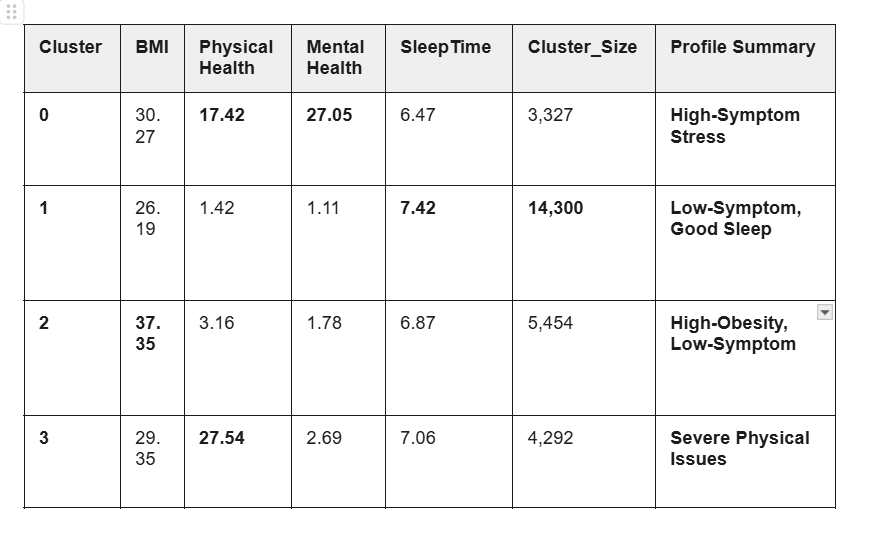